In [1]:
from utils.process_data import Process

In [2]:
import os

DATA_PATH = './data/cc_2018/'
files = [f for f in os.listdir(DATA_PATH)][1:8]
data_init = Process(files, DATA_PATH, 'test-output.pkl')
OVERWRITE = True

In [3]:
process_val = {'stopwords':'english',
               'stemmer':'yes',
               'ngrams':'trigrams'}

temp_ = data_init.remove_lines(OVERWRITE, data_init, **process_val)

file exists, loading data...
loaded...


In [4]:
params = {'vectorizor': 'tfidf',
          'max_df': 0.30,
          'min_df': 40}

x = data_init.vectorize(**params)

x

loading data...
loaded...
applying tfidf


<268x25 sparse matrix of type '<class 'numpy.float64'>'
	with 1325 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.decomposition import NMF
import pickle

if os.path.exists('./data/nmf-output.pkl') == False:
    print('processing nmf...')
    kmin, kmax = 4,15
    
    print(f'calculating nmf for k {kmin} to {kmax}...')
    d = {}
    for k in range(kmin,kmax+1):
        model = NMF(init='nndsvd', n_components=k) 
        d[k] = model.fit_transform(df_), model.components_ #collect W & H factors
    
    print('dumping file to pkl...')
    output = open('./data/nmf-output.pkl', 'wb')
    pickle.dump(d, output)
    output.close()
    print('done')
    
else:
    print('file exists, loading data...')
    
    pkl_file = open('./data/nmf-output.pkl', 'rb')
    d = pickle.load(pkl_file)
    pkl_file.close()
    
    print('loaded...')

file exists, loading data...
loaded...


In [14]:
import gensim

if os.path.exists('./data/w2v-model.bin') == False:
    print('preprocessing text data for w2v model')
    #w2v_raw = data_init.preprocess(temp_['USE Credit Union'], **process_val)
    
    processed = {k: data_init.preprocess(temp_[k], **process_val) for k in temp_.keys()}
    w2v_raw = pd.concat([processed[k] for k in processed.keys()],axis=0).reset_index().drop(['index'],axis=1)

    print('making w2v model')
    w2v_m = gensim.models.Word2Vec(w2v_raw[0], size=500, min_count=20, sg=1)

    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')
    w2v_m.save('./data/w2v-model.bin')
    
else:
    print('file exists...')
    w2v_m = gensim.models.Word2Vec.load('./data/w2v-model.bin')
    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')

file exists...
word2vec model has 176 terms


In [10]:
from sklearn.externals import joblib

(tfidf_,terms) = joblib.load('./data/tfidf-output.pkl')

In [15]:
from utils.topic_model import calculate_coherence, top_term

k_values, coherences = [],[]
for k in d.keys():
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = [top_term(terms, d[k][0], topic_index, 10) for topic_index in range(k)]

    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_m, term_rankings)) 

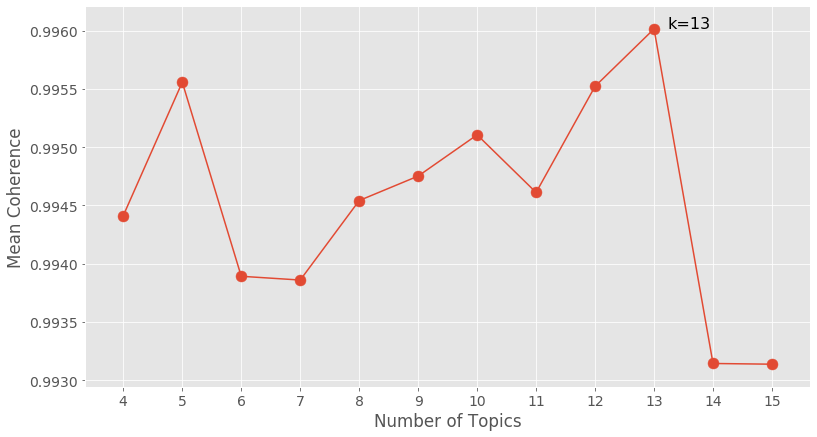

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot(k_values, coherences)
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [19]:
from utils.topic_model import get_top_snippets

k = best_k
W = d[k][0]
H = d[k][1]


sentences = [headline[0:min(len(headline),100)] for headline in data['headline']]
descriptors = [top_term(terms, H, topic_index, 10) for topic_index in range(k)]


for i in range(k):
    topic = i
    headlines = 15

    d_ = {i+1: [data[data['headline']==sentences]['category'].values[0], sentences]
             for i,sentences in enumerate(get_top_snippets(sentences, W, topic, headlines))
        }

    temp_ = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',1:'NMF categorized'})


    print('#''='*30)
    print(f'top terms for topic {topic}')
    print(descriptors[topic])

    print('='*50)
    gt_top = temp_['ground_truth'].value_counts().index[0]
    print(f'top ground truth label: {gt_top}')

    print('='*50)
    print(f'ground truth v. top headlines for topic {topic}')
    print(temp_)
    print('')

NameError: name 'data' is not defined